This notebook contains code to extract features from the audio signals.

In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [2]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [3]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [4]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

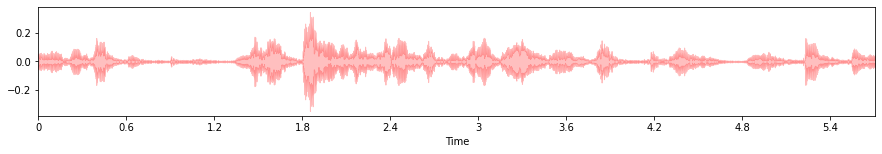

In [5]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

In [8]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.00260
Signal std dev = 0.00358


RMSE mean = 0.02500
RMSE std dev = 0.02053


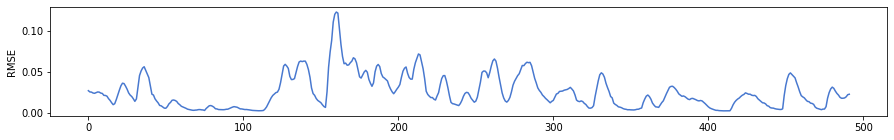

In [6]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [7]:
from IPython.display import Audio
Audio(y, rate=44100)

In [8]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.2764227642276423


In [9]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-3.4071943e-06

In [10]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

263.5684063188889

In [11]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

188.38608108440252

In [12]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [13]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [14]:
audio_vectors

{'Ses01M_impro06_F000': array([-0.00052653, -0.00080401, -0.00104455, ...,  0.00150115,
         0.00132334,  0.00125481], dtype=float32),
 'Ses01M_impro06_F001': array([-3.0450767e-04, -1.3179750e-04, -4.1875628e-05, ...,
         1.0978939e-03,  1.0899610e-03,  8.9708454e-04], dtype=float32),
 'Ses01M_impro06_F002': array([ 0.00088783,  0.00096229,  0.00107969, ..., -0.00230551,
        -0.002071  , -0.00184568], dtype=float32),
 'Ses01M_impro06_F003': array([ 0.00216814,  0.00222351,  0.00224553, ..., -0.00219907,
        -0.00171992, -0.00117805], dtype=float32),
 'Ses01M_impro06_F004': array([ 0.00543021,  0.00512988,  0.00488476, ..., -0.00226189,
        -0.00239431, -0.00242849], dtype=float32),
 'Ses01M_impro06_F005': array([-0.00328048, -0.00330121, -0.00319378, ..., -0.00129815,
        -0.00094876, -0.00048766], dtype=float32),
 'Ses01M_impro06_F006': array([-0.00289063, -0.00251914, -0.00205008, ..., -0.00175751,
        -0.00138914, -0.00091392], dtype=float32),
 'Ses01M_

In [15]:
labels_df = pd.read_csv(labels_path)

for sess in [6]: #range(2, 6):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                print('1. Session ', sess, ' file: ', wav_file_name)
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std

                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)
                print('2. Session ', sess, ' file: ', wav_file_name)
                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std
                print('3. Session ', sess, ' file: ', wav_file_name)
                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
                
                
            except:
                print('Some exception occured')
                print(wav_file_name)

df_features.to_csv('data/pre-processed/audio_features_'+ str(sess) +'.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/pre-processed/audio_vectors_6.pkl'